<a href="https://colab.research.google.com/github/itsmechand/TechnoHacks-DS/blob/main/Task5_Email_Spam_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from collections import Counter
from tensorflow import keras
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile
import string
import nltk
import re

In [2]:
zip_file = 'SMS Spam Collection Dataset.zip'

In [5]:
spam_dataset = pd.read_csv("task5_email_spam_filtering.csv",encoding='latin-1')
spam_dataset

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [6]:
columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
spam_dataset.drop(columns=columns_to_drop, inplace=True)


In [7]:
spam_dataset

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
spam_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
spam_dataset.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
spam_dataset.isna().sum()

v1    0
v2    0
dtype: int64

In [11]:
new_column_names = {"v1":"Category", "v2":"Message"}
spam_dataset.rename(columns = new_column_names, inplace = True)

In [12]:
spam_dataset.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


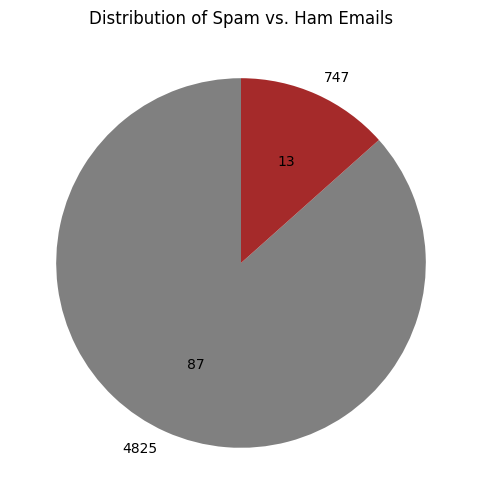

In [13]:
# Count the occurrences of each label
label_counts = spam_dataset['Category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Optional: Set the figure size
custom_colors = ['grey', 'brown']  # Replace with your desired colors

# Create the pie chart with custom colors
plt.pie(label_counts, labels=label_counts, autopct='%.0f', startangle=90, colors=custom_colors)

# Add a title
plt.title('Distribution of Spam vs. Ham Emails')

# Display the pie chart
plt.show()

In [16]:
spam_dataset['Message']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [17]:
spam_dataset.Message= spam_dataset.Message.str.split('|',expand=True)[0]
spam_dataset.Message

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [18]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
spam_dataset['cleaned text'] = spam_dataset['Message'].apply(clean)
spam_dataset.head()

,Category,Message,cleaned text
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup final ...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives arou...


In [19]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [20]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))

    return newlist

spam_dataset['POS tagged'] = spam_dataset['cleaned text'].apply(token_stop_pos)
spam_dataset.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,Category,Message,cleaned text,POS tagged
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[(Go, n), (jurong, a), (point, n), (crazy, n),..."
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[(Ok, n), (lar, a), (Joking, n), (wif, n), (u,..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup final ...,"[(Free, a), (entry, n), (wkly, a), (comp, n), ..."
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[(U, a), (dun, n), (say, v), (early, a), (hor,..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives arou...,"[(Nah, n), (think, n), (goes, v), (usf, v), (l..."


In [21]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    def get_wordnet_pos(tag):
        # Map POS tags to WordNet tags
        tag = tag[0].upper()
        tag_dict = {"J": "a", "N": "n", "R": "r", "V": "v"}
        return tag_dict.get(tag, "n")  # Default to noun if not found

    lemma_text = ""
    for word, pos in pos_tag(word_tokenize(text)):
        wordnet_pos = get_wordnet_pos(pos)
        lemma = wordnet_lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemma_text += lemma + " "

    return lemma_text.strip()

# Assuming you have a DataFrame named spam_dataset with a 'cleaned text' column
spam_dataset['Lemma'] = spam_dataset['cleaned text'].apply(lemmatize)
spam_dataset.head()

,Category,Message,cleaned text,POS tagged,Lemma
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[(Go, n), (jurong, a), (point, n), (crazy, n),...",Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[(Ok, n), (lar, a), (Joking, n), (wif, n), (u,...",Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup final ...,"[(Free, a), (entry, n), (wkly, a), (comp, n), ...",Free entry in a wkly comp to win FA Cup final ...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[(U, a), (dun, n), (say, v), (early, a), (hor,...",U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives arou...,"[(Nah, n), (think, n), (goes, v), (usf, v), (l...",Nah I don t think he go to usf he live around ...


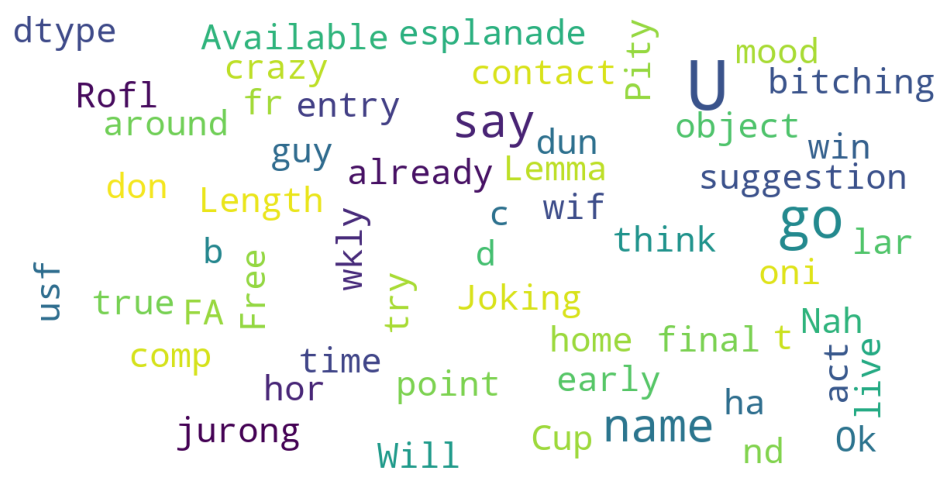

In [22]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(spam_dataset.Lemma)

In [23]:
spam_dataset.loc[spam_dataset["Category"] == "spam", "Category"] = 0
spam_dataset.loc[spam_dataset["Category"] == "ham", "Category"] = 1


In [24]:
x = spam_dataset['Lemma']
y = spam_dataset['Category']

In [25]:
x

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in a wkly comp to win FA Cup final ...
3             U dun say so early hor U c already then say
4       Nah I don t think he go to usf he live around ...
                              ...                        
5567    This be the nd time we have try contact u U ha...
5568                       Will b go to esplanade fr home
5569     Pity be in mood for that So any other suggestion
5570    The guy do some bitching but I act like i d be...
5571                             Rofl Its true to it name
Name: Lemma, Length: 5572, dtype: object

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

In [28]:
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [29]:
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [30]:
Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [32]:
print(X_train)

3075    Mum hope you be have a great day Hoping this t...
1787                               Yes sura in sun tv lol
1614    Me sef dey laugh you Meanwhile how s my darlin...
4304                Yo come over carlos will be here soon
3266                     Ok then i come n pick u at engin
                              ...                        
789                          Gud mrng dear hav a nice day
968              Are you willing to go for aptitude class
1667    So now my dad be gon na call after he get out ...
3321    Ok darlin i supose it be ok i just worry too m...
1688                        Nan sonathaya soladha Why bos
Name: Lemma, Length: 4457, dtype: object


In [33]:
print(X_train_features)

  (0, 11)	0.34714302127268243
  (0, 2859)	0.259065126893015
  (0, 3125)	0.24069110294379942
  (0, 5155)	0.21159484732940764
  (0, 2324)	0.41960842541287985
  (0, 1207)	0.39356089619150136
  (0, 2103)	0.4745775952225828
  (0, 2320)	0.2346262801420172
  (0, 3332)	0.313747671621413
  (1, 2924)	0.380431198316959
  (1, 5397)	0.4306015894277422
  (1, 4994)	0.4769136859540388
  (1, 5017)	0.5652509076654626
  (1, 5921)	0.35056971070320353
  (2, 189)	0.49562915179114375
  (2, 1195)	0.4243369407793275
  (2, 2801)	0.39366373824124706
  (2, 1298)	0.41673793884592675
  (2, 4486)	0.49562915179114375
  (3, 4762)	0.4957772298755618
  (3, 761)	0.5992249537976562
  (3, 969)	0.34420426692566747
  (3, 5932)	0.5259827142723181
  (4, 1569)	0.7559367078600187
  (4, 3812)	0.44020728356121047
  :	:
  (4452, 1207)	0.29470049623262534
  (4453, 247)	0.6767059962099998
  (4453, 5756)	0.5793673580358385
  (4453, 903)	0.45431537409161515
  (4454, 1174)	0.41641137162160197
  (4454, 2057)	0.3768289511370543
  (4454, 1

In [34]:
model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [35]:
predict_train_data=model.predict(X_train_features)
predict_train_data

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_train_data=accuracy_score(Y_train,predict_train_data)
print("Accuracy on training data: ",accuracy_train_data)

Accuracy on training data:  0.9699349338119811


In [37]:
predict_test_data=model.predict(X_test_features)

In [38]:
accuracy_test_data=accuracy_score(Y_test,predict_test_data)
print("acuuracy on test data: ",accuracy_test_data)

acuuracy on test data:  0.9614349775784753


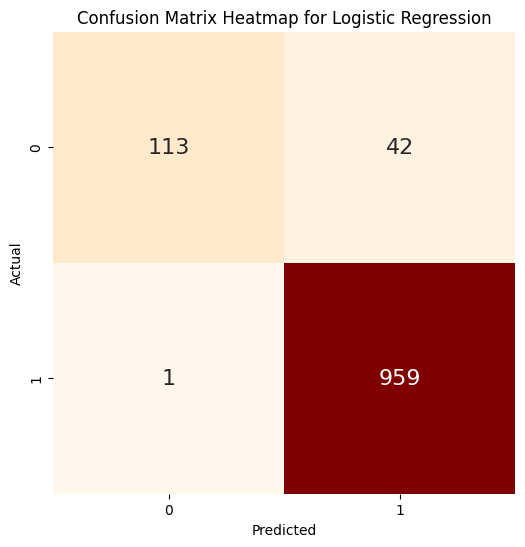

In [39]:
confusion = confusion_matrix(Y_test, predict_test_data)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='OrRd', cbar=False, square=True, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap for Logistic Regression')

plt.show()

In [40]:
svm = SVC()
svm.fit(X_train_features, Y_train)

SVC()

In [41]:
svm_train_prediction =  svm.predict(X_train_features)
svm_train_prediction

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
svmaccuracy_train_data=accuracy_score(svm_train_prediction,Y_train)
print("SVM Accuracy on training data: ",svmaccuracy_train_data)

SVM Accuracy on training data:  0.997083239847431


In [43]:
svmpredict_test_data=svm.predict(X_test_features)

In [44]:
svmaccuracy_test_data=accuracy_score(Y_test,svmpredict_test_data)
print("acuuracy on test data: ",svmaccuracy_test_data)

acuuracy on test data:  0.9811659192825112


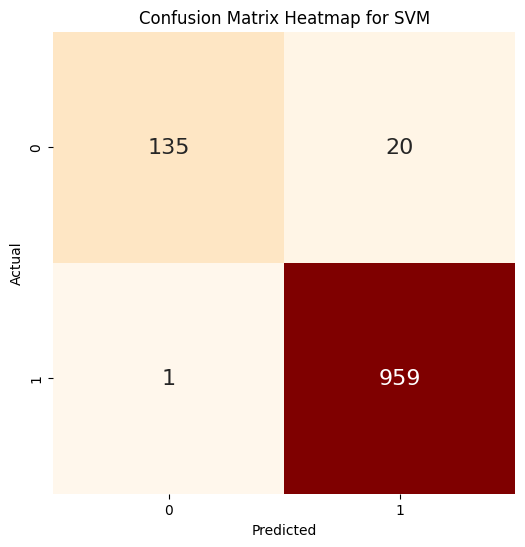

In [45]:
# Calculate the confusion matrix
confusion = confusion_matrix(Y_test, svmpredict_test_data)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='OrRd', cbar=False, square=True, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap for SVM')

plt.show()